In [1]:
from modules import expectedMultiBleu
import numpy as np
import torch
if torch.cuda.is_available():
    from torch.cuda import LongTensor, FloatTensor
else:
    from torch import LongTensor, FloatTensor
from torch.autograd import Variable
from torch.nn import Module, functional as F
# from modules.expectedBLEU import bleu as ebleu
from modules.expectedMultiBleu import bleu, calculate_overlap, bleu_with_bp, continuous_lengths
from modules.matrixBLEU import mBLEU
from matplotlib import pyplot as plt
from modules.utils import CUDA_wrapper
import time
plt.style.use('ggplot')
%matplotlib inline

In [2]:
probs = torch.autograd.Variable(torch.FloatTensor([[0.1, 0.9], [0.1, 0.9], [0.9, 0.1]]))

In [3]:
continuous_lengths(probs.unsqueeze(0), 0)

Variable containing:
 2.3670
[torch.FloatTensor of size 1]

# Toy experiment
Here we will implement described in article. We will try optimize $t$ matrix by minimizing expectedBLEU (see training function)

* Elements of matrix $t$ are generated by sampling logits from $N(0,1)$ and then $softmax$ function is applied row-wise to obtain probability distribution for words.
* Indexes of reference text $r$ are generated by uniform sampling with replacement from vocabulary.

In [4]:
def generate_batch_references(references_lengths, vocab_size):
    def _gen_padded_ref(l):
        ref = np.random.choice(vocab_size, size=l, replace=True)
        padding = np.array([0] * (max_len - l), dtype=int)
        return np.concatenate((ref, padding)).tolist()
    max_len = np.max(references_lengths)
    res = [_gen_padded_ref(l)\
           for l in references_lengths]
    return res

def _all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

def onehot_initialization(a, vocab_size):
    ncols = vocab_size
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[_all_idx(a, axis=2)] = 1
    return out

class MySoftmax(Module):

    def forward(self, input_):
        batch_size = input_.size()[0]
        output_ = torch.stack([F.softmax(input_[i]) for i in range(batch_size)], 0)
        return output_

In [5]:
from tqdm import  tqdm

np.random.seed(3)
torch.manual_seed(2)
class Optimization_experiment:
    def __init__(self, low_len = 8, hight_len = 10,\
                 batch_size = 1, translation_len = 10, vocab_size = 20000):
        self.batch_size = batch_size
        self.translation_len = translation_len
        self.vocab_size = vocab_size
        self.sm = MySoftmax()
        self.references_lengths = np.random.randint(low=low_len,\
                                        high=hight_len + 1, size=batch_size)
        self.t = Variable(CUDA_wrapper(\
                    torch.randn((batch_size, translation_len, vocab_size))),\
            requires_grad=True)
        self.references_batch = generate_batch_references(self.references_lengths, vocab_size)
        self.R = Variable(FloatTensor(onehot_initialization(\
                        np.array(self.references_batch), self.vocab_size).tolist()))
        self.mbl = mBLEU()
        
    def estimate_expected_bleu(self, number_of_samples):
        probs = self.sm(self.t)
        estimations = []
        for _ in range(number_of_samples):
            samples_batch = []
            for seq_probs in probs.data.cpu().numpy():
                samples = []
                for word_probs in seq_probs:
                    samples.append(np.random.multinomial(\
                            1, word_probs/np.sum(word_probs) - 1E-6))
                samples_batch.append(samples)
            samples_batch = CUDA_wrapper(\
                        torch.from_numpy(np.array(samples_batch).astype(np.float32)))
            estimation = self.mbl(self.R, Variable(samples_batch), self.references_lengths,\
                            LongTensor([self.translation_len] * self.batch_size))
            estimations.append(estimation[0].data.cpu()[0])
        return np.mean(estimations)
    
    def estimate_exact(self):
        return self.mbl(self.R, self.t, self.references_lengths,\
                        LongTensor([self.translation_len] * self.batch_size))
    
    def train(self, max_order=4, steps=100, number_of_samples=100):
        opt = torch.optim.Adam([self.t], lr=0.1)
        grad_norms = []
        bleu_lb = []
        start_time = time.time()
        estimations_ebleu = []
        exact_estimations = []
        for i in tqdm(range(steps)):
            probs = self.sm(self.t)
#             b = bleu(probs, self.references_batch, \
#                     LongTensor([self.translation_len] * self.batch_size),\
#                     self.references_lengths, max_order=max_order, smooth=True)
            b = bleu_with_bp(probs, self.references_batch,\
                    self.references_lengths, 0, max_order=max_order, smooth=True)
            if i < 10:
                b[0].backward()
            else:
                reinforce_bleu(probs, self.references_batch, {i: str(i) for i in range(20001)})
#             b_no_smooth = bleu(probs, self.references_batch, \
#                 LongTensor([self.translation_len] * self.batch_size),\
#                 self.references_lengths, max_order=max_order, smooth=False)
#             bleu_lb.append(-b_no_smooth[0].data[0])
            bleu_lb.append(-b[0].data[0])
            opt.step()
            grad_norms.append(self.t.grad.data.norm())
            estimations_ebleu.append(-self.estimate_expected_bleu(number_of_samples))
            exact_estimations.append(-self.estimate_exact()[0].data.cpu()[0])
        return exact_estimations, estimations_ebleu, bleu_lb, grad_norms
exp = Optimization_experiment(batch_size=2)

In [6]:
probs = exp.sm(exp.t)
r = exp.references_batch
eos_id = 0
# continuous_lengths(probs, eos_id)
# bleu_with_bp(probs, r, exp.references_lengths, 0)

In [7]:
from TF_GOOGLE_NMT import compute_bleu
def _transform_seq_to_sent(seq, vcb):
    return ' '.join([vcb[i] for i in seq])

def transform_tensor_to_list_of_snts(tensor, vcb):
    if isinstance(tensor, Variable):
        np_tens = tensor.data.cpu().numpy()
    else:
        np_tens = tensor.cpu().numpy()
    snts = []
    end_snt = "</s>"
    for i in np_tens:
        cur_snt = _transform_seq_to_sent(i, vcb)
        snts.append(cur_snt[:cur_snt.index(end_snt) if end_snt in cur_snt else len(cur_snt)].split())
    return snts

def bleu_score(outputs, reference, vcb_id2word, corpus_average=True):
    hypothesis = transform_tensor_to_list_of_snts(outputs, vcb_id2word)
    reference = [_transform_seq_to_sent(i, vcb_id2word).split() for i in reference]
    reference = [[cur_ref] for cur_ref in reference]
    list_of_hypotheses = hypothesis
    list_of_references = reference
    if corpus_average:
        return compute_bleu(list_of_references, list_of_hypotheses)[0]
    else:
        return [compute_bleu([reference], [hypothesis])[0]\
                for reference, hypothesis\
                in zip(list_of_references, list_of_hypotheses)]

In [8]:
def reinforce_bleu(probs: Variable, refs: list, vcb: dict, corpora=False):
    list_of_samples = [torch.multinomial(probs[i], 1) \
                              for i in range(probs.data.shape[0])]
    sample = torch.stack(list_of_samples).squeeze()
    argmax_sample = torch.stack([torch.max(probs[i], dim=1)[1] \
                              for i in range(probs.data.shape[0])])
    if corpora:
        sample_bleu = bleu_score(sample, refs, vcb)
        argmax_bleu = bleu_score(argmax_sample, refs, vcb)
    else:
        sample_bleu = np.array(bleu_score(sample, refs, vcb, corpus_average=False))
        argmax_bleu = np.array(bleu_score(argmax_sample, refs, vcb, corpus_average=False))
    advantage = sample_bleu - argmax_bleu

    for i_id, i in enumerate(list_of_samples):
        if corpora:
            i.reinforce(CUDA_wrapper(FloatTensor([advantage] * i.size()[0]).view(-1, 1)))
        else:
            i.reinforce(CUDA_wrapper(FloatTensor([advantage[i_id]] * i.size()[0]).float()).view(-1, 1))
    torch.autograd.backward(list_of_samples, [None for _ in list_of_samples])

In [9]:
exact_estimations, estimations_ebleu,\
            bleu_lb, grad_norms = exp.train(steps=1000,number_of_samples=0)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/vlad/miniconda3/envs/torch/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vlad/miniconda3/envs/torch/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [01:37<00:00, 10.26it/s]


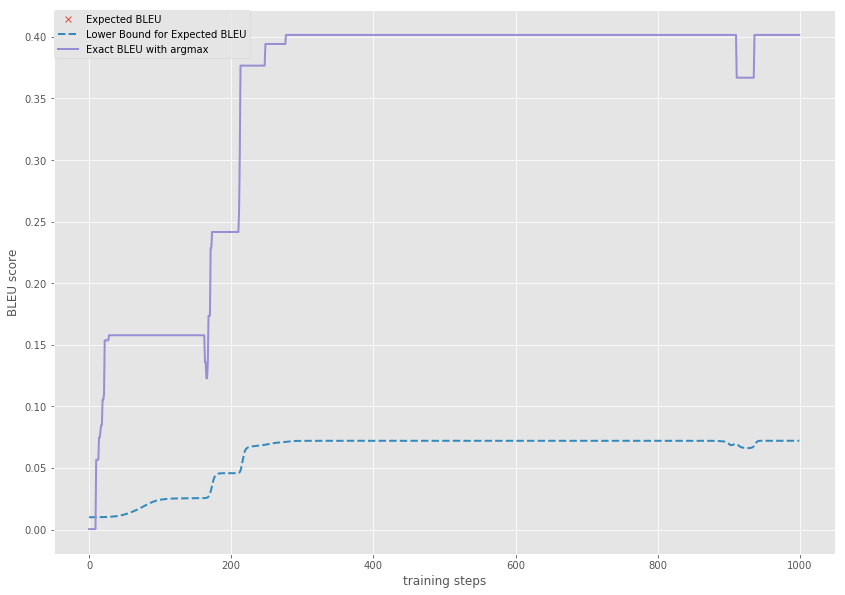

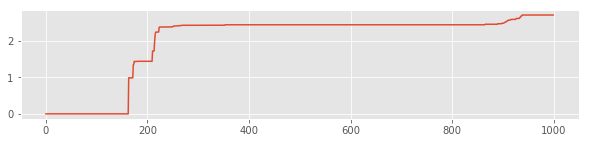

In [10]:
plt.figure(figsize=(14, 10))
plt.plot(estimations_ebleu, 'x', linewidth=6, label='Expected BLEU')
plt.plot(bleu_lb, '--', linewidth=2, label='Lower Bound for Expected BLEU')
plt.plot(exact_estimations, '-', linewidth=2, label='Exact BLEU with argmax')
plt.ylabel('BLEU score')
plt.xlabel('training steps')
plt.legend(loc=2, borderaxespad=0.)
plt.figure(figsize=(10, 2))
plt.plot(grad_norms)
plt.show()